<a href="https://colab.research.google.com/github/slayer6996/Tesla-stock-price-prediction/blob/main/TSLA_stock_price_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas_datareader as pdr

In [3]:
key=""
df=pdr.get_data_tiingo('TSLA',api_key=key)

In [4]:
df.to_csv('tesla.csv')

In [5]:
import pandas as pd
df=pd.read_csv('tesla.csv')

In [6]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,TSLA,2016-10-31 00:00:00+00:00,197.73,202.4900,195.8100,202.49,4692273,39.546,40.49800,39.16200,40.498,23461365,0.0,1.0
1,TSLA,2016-11-01 00:00:00+00:00,190.79,198.5000,188.1050,198.04,7060036,38.158,39.70000,37.62100,39.608,35300180,0.0,1.0
2,TSLA,2016-11-02 00:00:00+00:00,188.02,192.6951,187.5050,190.05,4253382,37.604,38.53902,37.50100,38.010,21266910,0.0,1.0
3,TSLA,2016-11-03 00:00:00+00:00,187.42,191.4700,187.0401,189.00,2653023,37.484,38.29400,37.40802,37.800,13265115,0.0,1.0
4,TSLA,2016-11-04 00:00:00+00:00,190.56,193.4600,185.9600,189.00,5146043,38.112,38.69200,37.19200,37.800,25730215,0.0,1.0


In [7]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,TSLA,2021-10-22 00:00:00+00:00,909.68,910.00,890.96,895.500,22880835,909.68,910.00,890.96,895.500,22880835,0.0,1.0
1254,TSLA,2021-10-25 00:00:00+00:00,1024.86,1045.02,944.20,950.530,62852099,1024.86,1045.02,944.20,950.530,62852099,0.0,1.0
1255,TSLA,2021-10-26 00:00:00+00:00,1018.43,1094.94,1001.44,1024.690,62414968,1018.43,1094.94,1001.44,1024.690,62414968,0.0,1.0
1256,TSLA,2021-10-27 00:00:00+00:00,1037.86,1070.88,1030.78,1039.660,38526459,1037.86,1070.88,1030.78,1039.660,38526459,0.0,1.0
1257,TSLA,2021-10-28 00:00:00+00:00,1077.04,1081.00,1054.20,1068.305,27213173,1077.04,1081.00,1054.20,1068.305,27213173,0.0,1.0


In [8]:
df1=df.reset_index()['high']
df1

0        202.4900
1        198.5000
2        192.6951
3        191.4700
4        193.4600
          ...    
1253     910.0000
1254    1045.0200
1255    1094.9400
1256    1070.8800
1257    1081.0000
Name: high, Length: 1258, dtype: float64

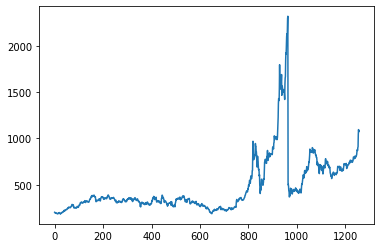

In [9]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [10]:
### applying MinMax scaler as LSTM is sensitive to scale of data
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.00832334],
       [0.0064534 ],
       [0.00373289],
       ...,
       [0.42657562],
       [0.41529975],
       [0.42004255]])

In [11]:
### splitting data for training and testing
training_size=int(len(df1)*0.75)
testing_size=len(df1)-training_size
data_train,data_test=df1[:training_size,:],df1[training_size:len(df1),:1]
training_size,testing_size

(943, 315)

In [12]:
#conversion of array to matrix
import numpy
def create_ds(dataset,timeStep=1):
  x_data,y_data=[],[]
  for i in range(len(dataset)-timeStep-1):
    a=dataset[i:(i+timeStep),0]
    x_data.append(a)
    y_data.append(dataset[i+timeStep,0])
  return numpy.array(x_data),numpy.array(y_data)

In [13]:
timeStep=100
x_train,y_train=create_ds(data_train,timeStep)
x_test,y_test=create_ds(data_test,timeStep)
x_train.shape , y_train.shape

((842, 100), (842,))

In [14]:
### reshaping input as [samples,time steps,features] for LSTM
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [15]:
### stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model=Sequential([
                  LSTM(50,return_sequences=True, input_shape=(100,1)),
                  LSTM(50,return_sequences=True),
                  LSTM(50),
                  Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=64,epochs=100)

Epoch 1/100
14/14 [==============================] - 9s 289ms/step - loss: 0.0091 - val_loss: 0.0051
Epoch 2/100
14/14 [==============================] - 3s 187ms/step - loss: 0.0017 - val_loss: 9.9746e-04
Epoch 3/100
14/14 [==============================] - 3s 187ms/step - loss: 0.0010 - val_loss: 9.6435e-04
Epoch 4/100
14/14 [==============================] - 3s 194ms/step - loss: 9.5661e-04 - val_loss: 0.0012
Epoch 5/100
14/14 [==============================] - 3s 193ms/step - loss: 9.3105e-04 - val_loss: 8.1445e-04
Epoch 6/100
14/14 [==============================] - 3s 194ms/step - loss: 9.4812e-04 - val_loss: 8.7272e-04
Epoch 7/100
14/14 [==============================] - 3s 189ms/step - loss: 8.8300e-04 - val_loss: 0.0012
Epoch 8/100
14/14 [==============================] - 3s 193ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 9/100
14/14 [==============================] - 3s 197ms/step - loss: 0.0010 - val_loss: 7.5510e-04
Epoch 10/100
14/14 [==============================] - 3

In [17]:
import tensorflow as tf
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)


In [18]:
### root mean squared error performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

454.3215402746841

In [19]:
### test data root mean squared error
math.sqrt(mean_squared_error(y_test,test_predict))

730.4461233921998

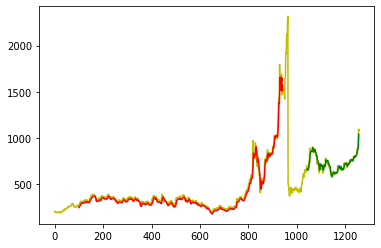

In [21]:
#plot
### shifting train predictions
look_back=100
train_predict_plot=numpy.empty_like(df1)
train_predict_plot[:,:]=np.nan
train_predict_plot[look_back:len(train_predict)+look_back,:]=train_predict

### shifting test predictions
test_predict_plot=numpy.empty_like(df1)
test_predict_plot[:,:]=numpy.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(df1)-1,:]=test_predict

plt.plot(scaler.inverse_transform(df1),'y')
plt.plot(train_predict_plot,'r')
plt.plot(test_predict_plot,'g')
plt.show()